In [1]:
from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot as plt
from sklearn import model_selection

%matplotlib inline
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [7]:
def bias(y, z):
    return - 2 * (z - y)

In [8]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [9]:
# Число деревьев в ансамбле
n_trees = 10

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [10]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [11]:
import matplotlib.pyplot as plt

In [12]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(1, n_trees+1)), train_err, label='train error')
    plt.plot(list(range(1, n_trees+1)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

## Домашние задания

1. Задание.
    - Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
    - Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
    - Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [13]:
n_trees = 15
max_depth = 4
eta_list = [5e-1, 5e-2, 5e-3,]

In [14]:
%%time

train_errors_list = []
test_errors_list = []
for i in range(len(eta_list)):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta_list[i])
    train_errors_list.append(train_errors)
    test_errors_list.append(test_errors)
    

Wall time: 26.6 s


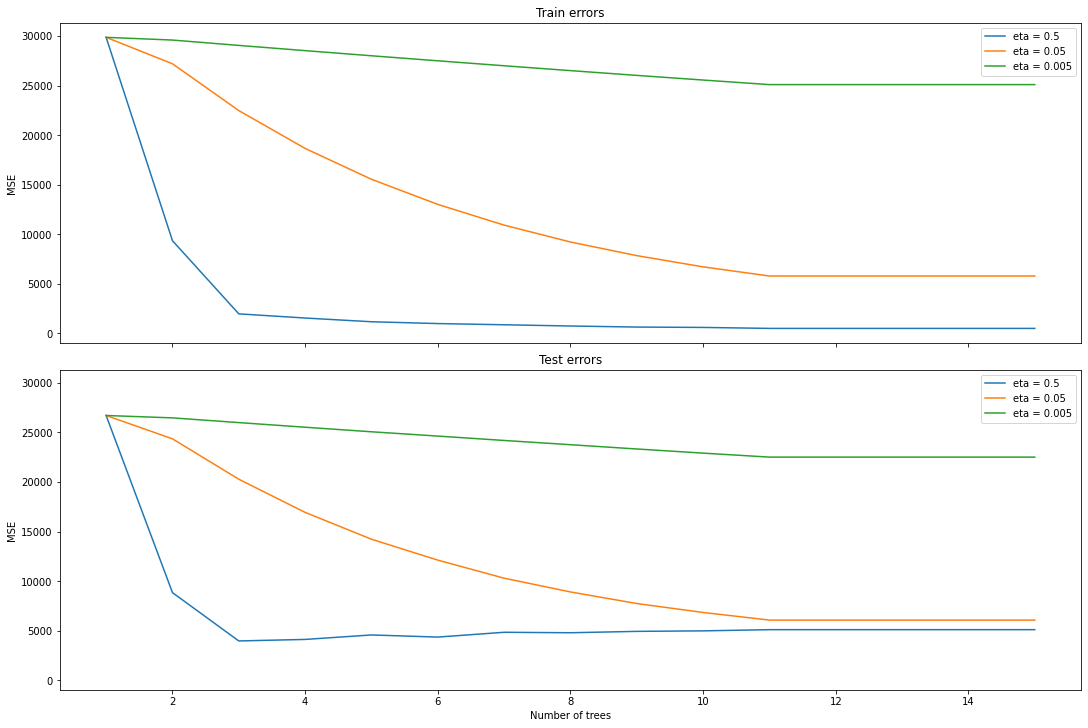

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True, figsize=(15,10))
for i in range(len(eta_list)):
    ax1.plot(list(range(1, n_trees+1)), train_errors_list[i], label=f'eta = {eta_list[i]}')
ax1.set_title('Train errors')
ax1.set_xlabel('')
ax1.set_ylabel('MSE')
ax1.legend(loc='upper right')
for i in range(len(eta_list)):
    ax2.plot(list(range(1, n_trees+1)), test_errors_list[i], label=f'eta = {eta_list[i]}')
ax2.set_title('Test errors')
ax2.set_xlabel('Number of trees')
ax2.set_ylabel('MSE')
ax2.legend(loc='upper right')
plt.show()

In [16]:
n_trees = 15
max_depth_list = [1, 2, 3, 4, 5]
eta = 5e-1

In [17]:
%%time

train_errors_list = []
test_errors_list = []
for i in range(len(max_depth_list)):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth_list[i], X_train, X_test, y_train, y_test, coefs, eta)
    train_errors_list.append(train_errors)
    test_errors_list.append(test_errors)
    

Wall time: 36.1 s


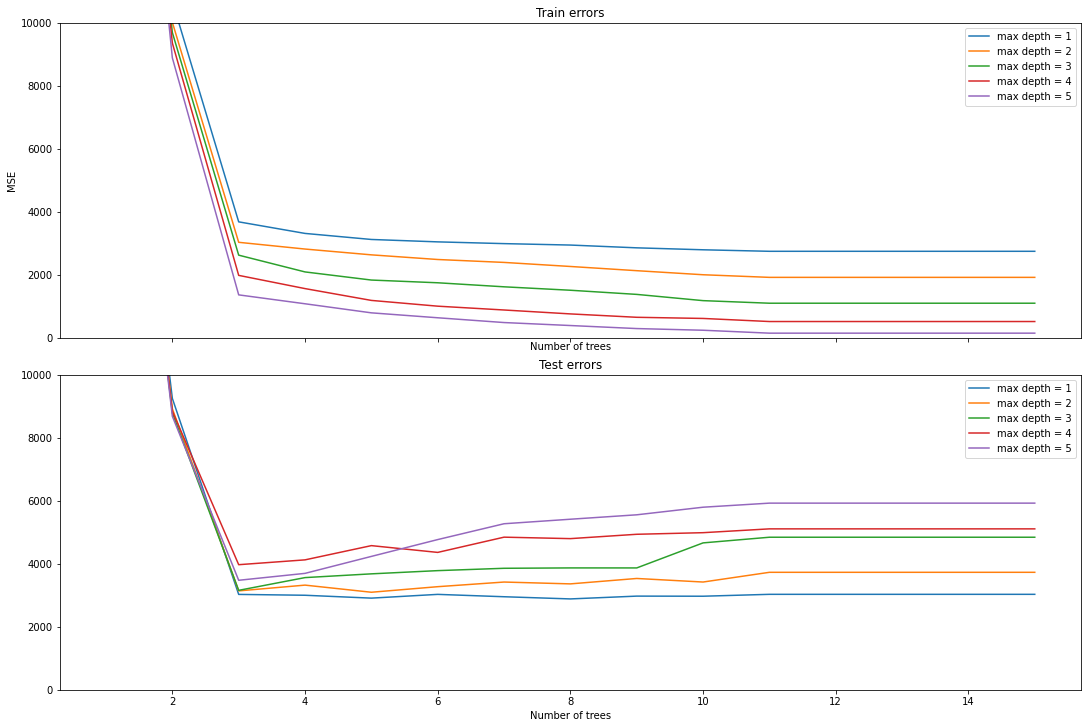

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True, figsize=(15,10))
for i in range(len(max_depth_list)):
    ax1.plot(list(range(1, n_trees+1)), train_errors_list[i], label=f'max depth = {max_depth_list[i]}')
ax1.set_title('Train errors')
ax1.set_xlabel('Number of trees')
ax1.set_ylabel('MSE')
ax1.legend(loc='upper right')
for i in range(len(max_depth_list)):
    ax2.plot(list(range(1, n_trees+1)), test_errors_list[i], label=f'max depth = {max_depth_list[i]}')
ax2.set_title('Test errors')
ax2.set_xlabel('Number of trees')
ax2.set_ylabel('')
ax2.legend(loc='upper right')
plt.ylim(0, 10000)
plt.show()

На тестовых данных наилучшие результаты показывают модели со скоростью обучения 0.5, количеством деревьев 3 и максимальной глубиной 1.

In [19]:
n_trees = 3
max_depth = 1
eta = 5e-1

In [20]:
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)    

In [21]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 3 деревьев глубиной 1     с шагом 0.5 на тренировочной выборке: 3312
Ошибка алгоритма из 3 деревьев глубиной 1     с шагом 0.5 на тестовой выборке: 3002
